# Predicting Customer Churn

## 1. Problem Definition

> Can we predict whether a customer will churn? 
* Note: Churn rate is the rate at which customer's stopped using a product or service provided by a company ie dropping a subscription service.

## 2. Data 

The data came from the Telco Customer Churn data set from Kaggle: https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download

## 3. Evaluation
> We will try to maximize the recall of the churn value (1) due to the fact that it is cheaper to keep a current customer than to gain a new one.

## 4. Features
* customerID
* gender (male or female)
* SeniorCitizen (1 senior; 0 not)
* Partner:  whether the customer has a partner or not
* Dependents:  whether the customer has dependents or not
* tenure:  number of months the customer has stayed with the company
* PhoneService:  whether they have the service or not
* MultipleLines:  whether the customer has multiple lines
* InternetService:  DSL, Fiber Optic, or No
* OnlineSecurity:  Yes, No, No internet service
* OnlineBackup:  Yes, No, No internet service
* DeviceProtection:  Yes, No, No internet service
* TechSupport:  whether the customer has tech support
* StreamingTv:  Yes, No, No internet service
* StreamingMovies:  Yes, No, No internet service
* Contract:  type: month-to-month, one year, two year
* PaperlessBilling:  whether the customer uses paperless billing
* Payment method:  Electronic check, mailed check, bank transfer, credit card
* MonthlyCharges:  amount charged monthly
* TotalCharges: total amount charged
* Churn:  whether the customer churned or not

In [1]:
# Import all modules we will use

# For dataprep/EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("pastel")
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder 

# Machine Learning Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# For model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, precision_recall_curve

In [2]:
# Import data 
df = pd.read_csv('cust-churn.csv')
df.shape

(7043, 21)

## EDA

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# We do not need the customerID column so we will drop it for simplicity
df.drop('customerID', axis = 1, inplace=True)

<Axes: >

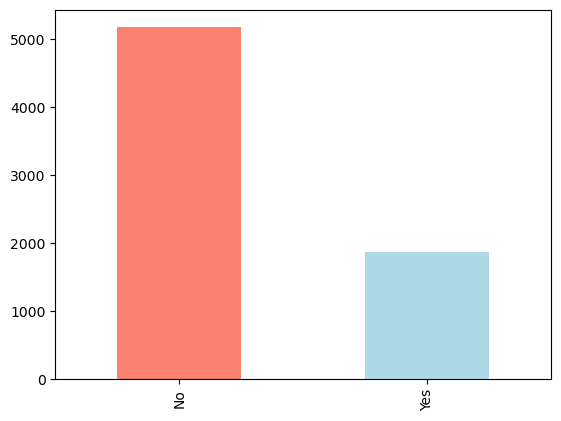

In [5]:
# Counts of Churn column
df.Churn.value_counts().plot(kind='bar', color=['salmon', 'lightblue'])

We notice above that our data is highly imbalanced, so we will use SMOTE to balance our data set later in the process

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


We notice we will need to change some of our columns from object to numerical

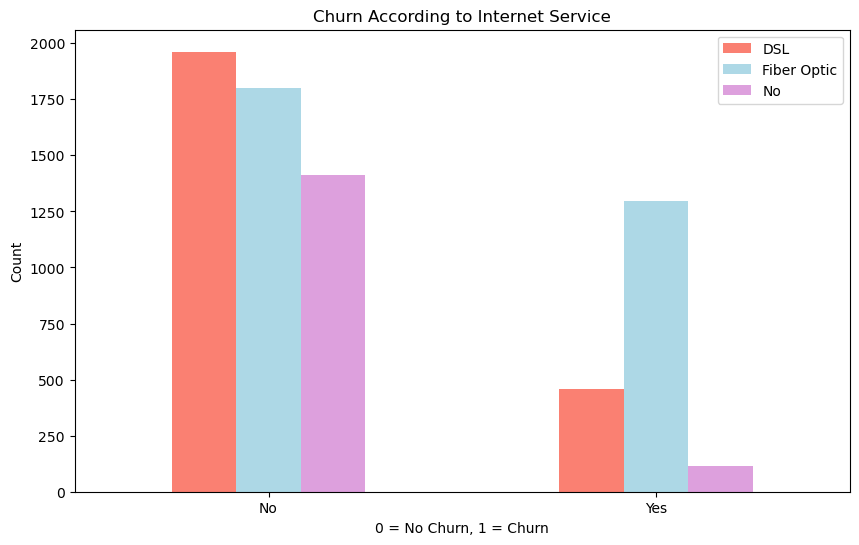

In [7]:
# Churn frequency per each internet service type
pd.crosstab(df.Churn, df.InternetService).plot(kind = 'bar',
                                      figsize = (10, 6),
                                      color = ['salmon', 'lightblue', 'plum'])

plt.title('Churn According to Internet Service')
plt.xlabel('0 = No Churn, 1 = Churn')
plt.ylabel('Count')
plt.legend(['DSL', 'Fiber Optic', 'No']);
plt.xticks(rotation = 0);

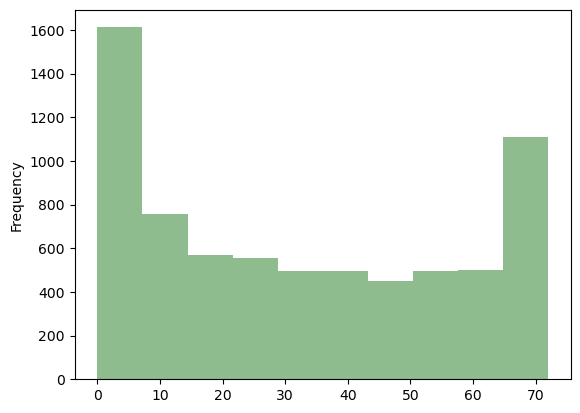

In [8]:
# Distribution of tenure
df.tenure.plot.hist(color = 'darkseagreen');

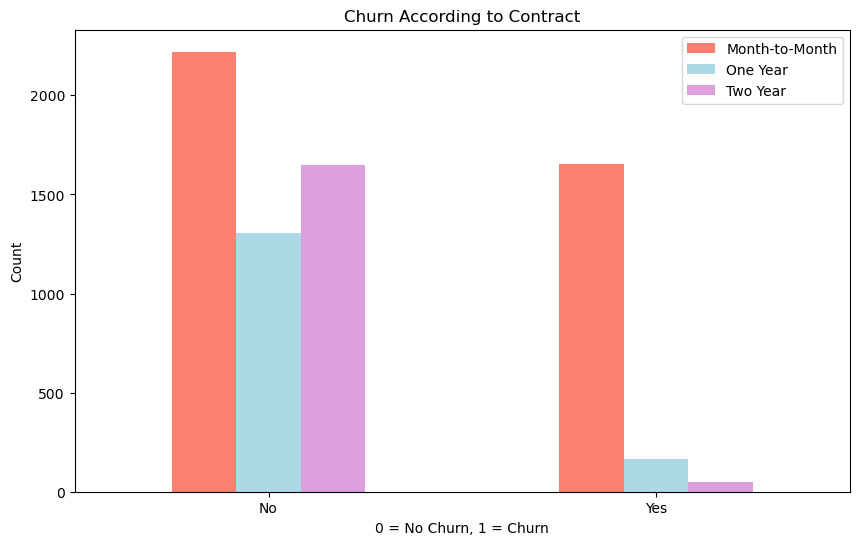

In [9]:
# Churn frequency per Contract type
pd.crosstab(df.Churn, df.Contract).plot(kind = 'bar',
                                      figsize = (10, 6),
                                      color = ['salmon', 'lightblue', 'plum'])

plt.title('Churn According to Contract')
plt.xlabel('0 = No Churn, 1 = Churn')
plt.ylabel('Count')
plt.legend(['Month-to-Month', 'One Year', 'Two Year']);
plt.xticks(rotation = 0);

In [10]:
# We have to first change the type of TotalCharges and Churn to numeric
# Force total charges column to numeric
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')


# Create lists of binary and multiclass columns in order to convert them
binary_categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 
                     'PaymentMethod', 'Churn']
multi_class_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 
                     'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'Contract']

# Instantiate label encoder
le = LabelEncoder()

# Change the binary variables by label encoding
for col in binary_categorical_cols:
    df[col] = le.fit_transform(df[col])

# Change multiclass by dummy variables
df = pd.get_dummies(df, columns = multi_class_cols, drop_first = True)

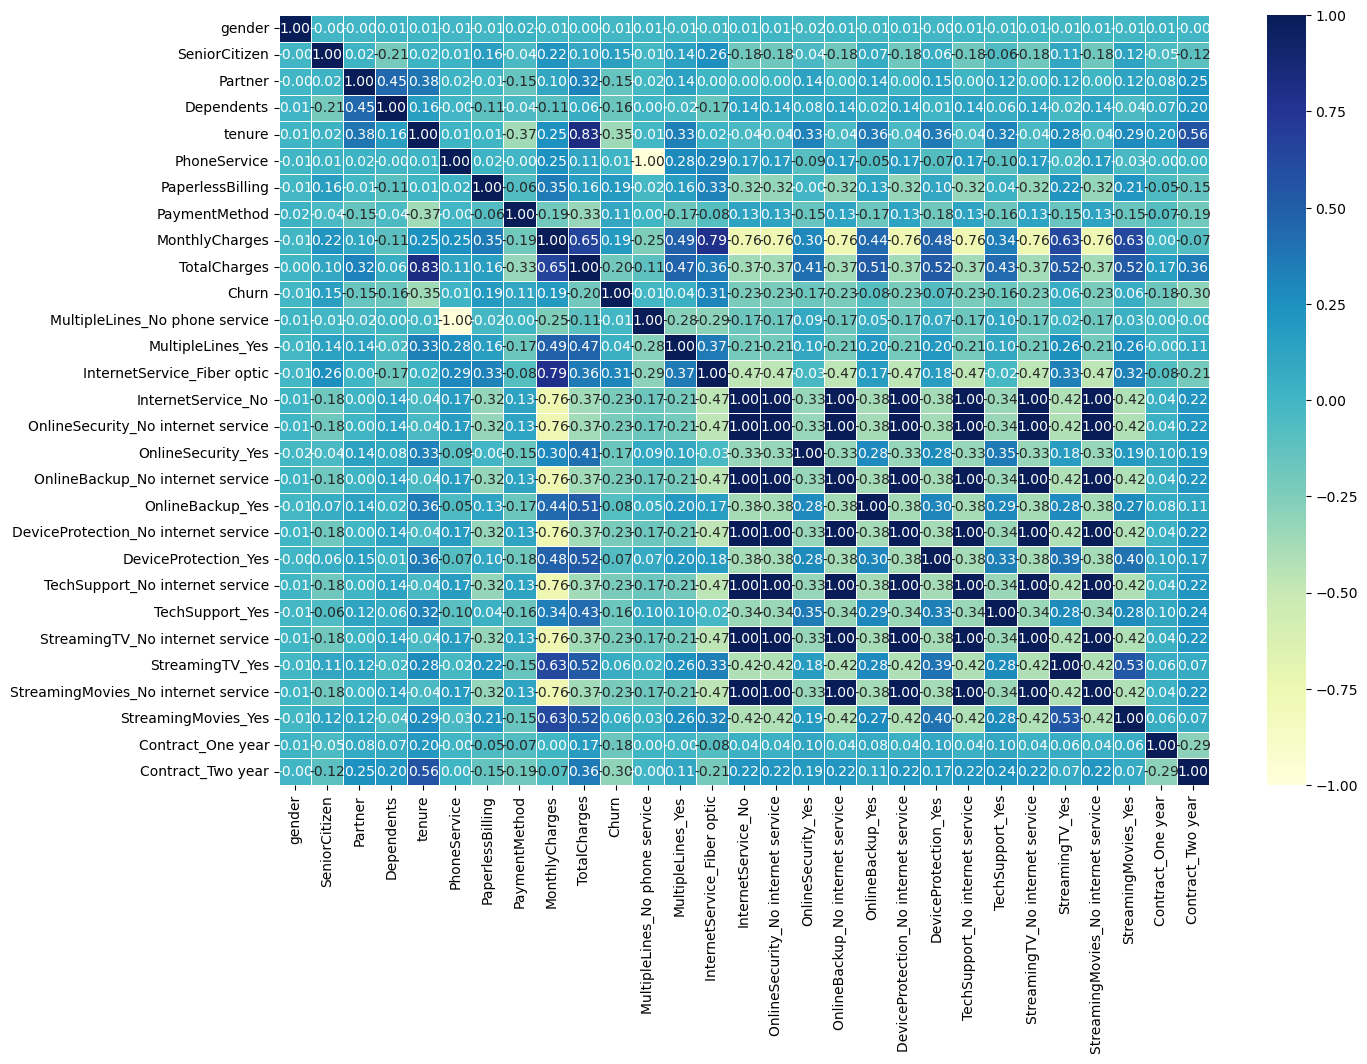

In [11]:
# Make a correlation matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.heatmap(corr_matrix,
                 annot = True,
                 linewidths = 0.5,
                 fmt = '.2f',
                 cmap = 'YlGnBu');

## 5. Modelling

In [12]:
# Split data into X & y
X = df.drop('Churn', axis = 1)
y = df.Churn

<Axes: >

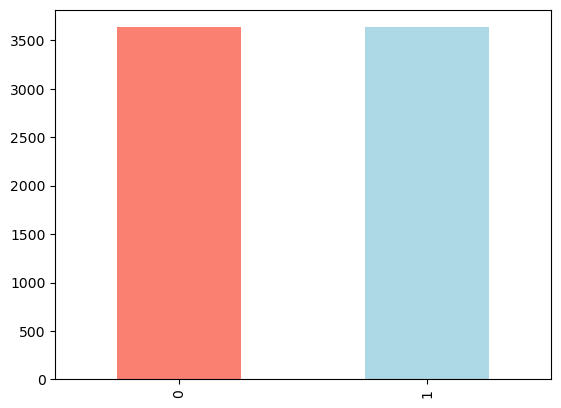

In [13]:
# Split into train and test sets
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


# We have to fill the na values in TotalCharges in order to apply smote, but we
# want to do it after we split as to not change the test set and then also fill
# the test set nan values with the mean value of the train set
X_train['TotalCharges'] = X_train['TotalCharges'].fillna(X_train['TotalCharges'].mean())
X_test['TotalCharges'] = X_test['TotalCharges'].fillna(X_train['TotalCharges'].mean())


# Instantiate and oversample the minority class (Churn or 1)
smote = SMOTE()

np.random.seed(42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Counts of Churn column after smote (only on the train set)
y_train_smote.value_counts().plot(kind='bar', color=['salmon', 'lightblue'])

In [14]:
# Put models into a dictionary
models = {'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'Random Forest': RandomForestClassifier(),
          'SVC': SVC()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    
    # Set random seed
    np.random.seed(42)
    
    # Make a dictionary to keep model scores
    model_scores = {}
    
    # Loop through all the models
    for name, model in models.items():
        # Fit teh model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
        
    return model_scores


C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.7628963558920966,
 'KNN': 0.7094178892569806,
 'Random Forest': 0.7695220066256507,
 'SVC': 0.6814955040227165}

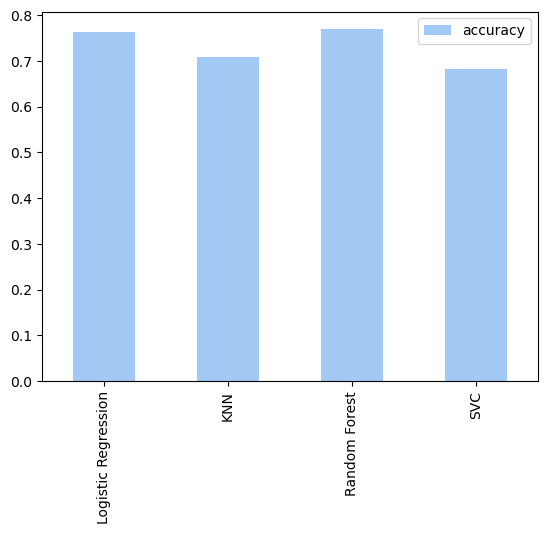

In [15]:
model_scores = fit_and_score(models,X_train_smote, X_test, y_train_smote,
                             y_test)
model_compare = pd.DataFrame(model_scores, index = ['accuracy'])
model_compare.T.plot.bar();
model_scores

### Hyperparameter Tuning and Cross-Validation

In [16]:
# Tune KNN
train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors = i)
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(X_train, y_train))
    
    # Update test scores list
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data: 79.08%


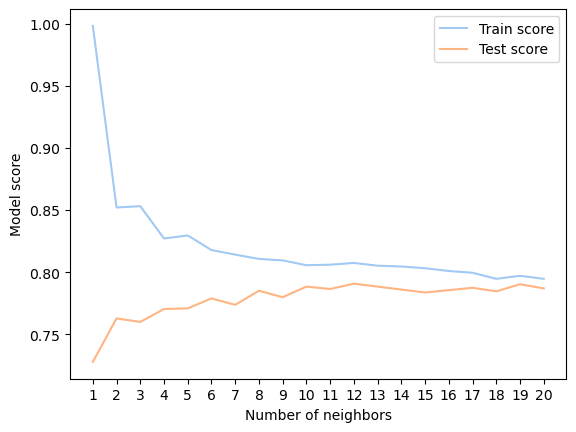

In [17]:
plt.plot(neighbors, train_scores, label = 'Train score')
plt.plot(neighbors, test_scores, label = 'Test score')
plt.xticks(np.arange(1, 21, 1))
plt.xlabel('Number of neighbors')
plt.ylabel('Model score')
plt.legend()

print(f'Maximum KNN score on the test data: {max(test_scores) * 100:.2f}%')

In [18]:
# Create grids to tune LogisticRegression, RandomForest, and SVC
log_reg_grid = {'penalty': ['l2', 'l1', 'elasticnet'],
                'C': np.logspace(-4, 4, 20),
                'solver': ['liblinear', 'sag', 'saga']}

rf_grid = {'n_estimators': np.arange(10, 1000, 50),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2)}

svc_grid = {'C': np.arange(0.1, 5, 20),
            'gamma': list(np.arange(0.01, 5, 10)),
            'kernel': ['rbf', 'linear']}

In [19]:
# Tune Logistic Regression Model

np.random.seed(42)

# Setup random search grid
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions = log_reg_grid,
                                cv = 5,
                                n_iter = 20,
                                verbose = True)

# Fit the model for Logistic Regression
rs_log_reg.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'penalty': ['l2', 'l1', 'elasticnet'],
                                        'solver': ['liblinear', 'sag', 'saga']},
                   verbose=True)

In [20]:
rs_log_reg.score(X_test, y_test)

0.7756743965925225

In [21]:
# Tune our Random Forest Classifier
np.random.seed(42)

# Setup the random search for our Random Forest
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions = rf_grid,
                           cv = 5,
                           n_iter = 20,
                           verbose = True)

# Fit the model
rs_rf.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [22]:
rs_rf.score(X_test, y_test)

0.7808802650260294

In [23]:
# Tune our Support Vector Classifier
np.random.seed(42)

# Setup the random search for our SVC
rs_svc = RandomizedSearchCV(SVC(),
                            param_distributions = svc_grid,
                            cv = 5, 
                            n_iter = 20,
                            verbose = True)

# Fit the model
rs_svc.fit(X_train_smote, y_train_smote)

C:\Users\Brady\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=20,
                   param_distributions={'C': array([0.1]), 'gamma': [0.01],
                                        'kernel': ['rbf', 'linear']},
                   verbose=True)

In [24]:
rs_svc.score(X_test, y_test)

0.780407004259347

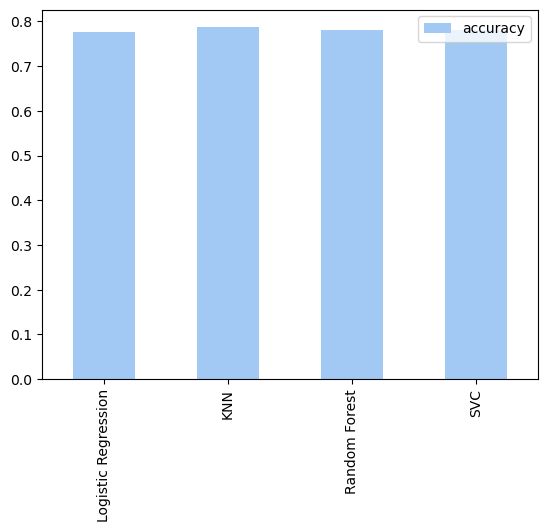

In [25]:
model_scores = {'Logistic Regression': rs_log_reg.score(X_test, y_test),
                'KNN': knn.score(X_test, y_test),
                'Random Forest': rs_rf.score(X_test, y_test),
                'SVC': rs_svc.score(X_test, y_test)}

model_compare = pd.DataFrame(model_scores, index = ['accuracy'])
model_compare.T.plot.bar();

In [26]:
# We will tune our Random Forest with grid search
rf_grid = {'n_estimators': np.arange(10, 500, 100),
           'max_depth': [5, 10],
           'min_samples_split': np.arange(1, 15, 3),
           'min_samples_leaf': np.arange(1, 15, 3)}

gs_rf = GridSearchCV(RandomForestClassifier(),
                     param_grid = rf_grid,
                     cv = 5, 
                     verbose = True)

# Fit grid Random Forest model
gs_rf.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10],
                         'min_samples_leaf': array([ 1,  4,  7, 10, 13]),
                         'min_samples_split': array([ 1,  4,  7, 10, 13]),
                         'n_estimators': array([ 10, 110, 210, 310, 410])},
             verbose=True)

In [27]:
gs_rf.score(X_test, y_test)

0.7756743965925225

In [28]:
# We will tune our Logistic Regression with grid search
log_reg_grid = {'penalty': ['l2', 'l1', 'elasticnet'],
              'C': np.logspace(-4, 4, 20),
              'solver': ['liblinear', 'sag', 'saga']}

gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid = log_reg_grid,
                          cv = 5,
                          verbose = True)

# Fit grid Logistic Regression model
gs_log_reg.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'solver': ['liblinear', 'sag', 'saga']},
             verbose=True)

In [29]:
gs_log_reg.score(X_test, y_test)

0.7756743965925225

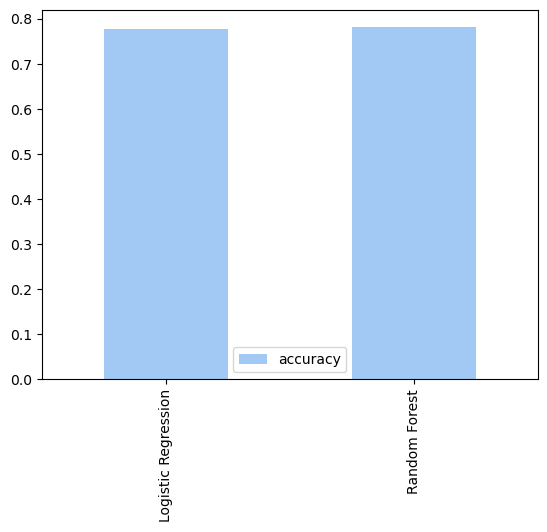

In [30]:
model_scores = {'Logistic Regression': rs_log_reg.score(X_test, y_test),
                'Random Forest': rs_rf.score(X_test, y_test)}

model_compare = pd.DataFrame(model_scores, index = ['accuracy'])
model_compare.T.plot.bar();

### ROC Curve and AUC score, Confusion Matrix, Classification Report, Precision, Recall, and F1-Score

In [31]:
# Function to produce all our ROC curves
def print_roc_curve(models, X_test, y_test):
    
    for name, estimator in models.items():
        RocCurveDisplay.from_estimator(estimator, X_test, y_test)
        plt.title(f'ROC Curve - {name}')

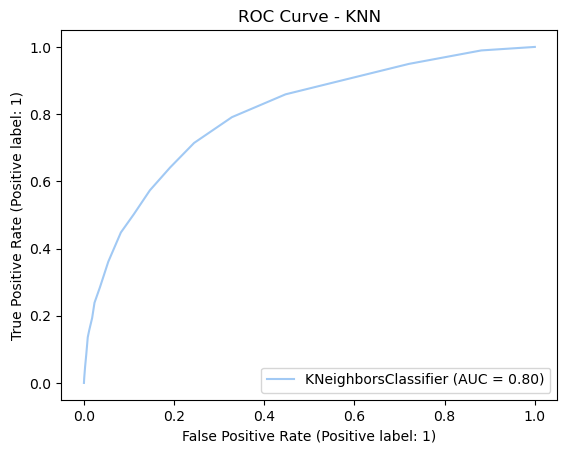

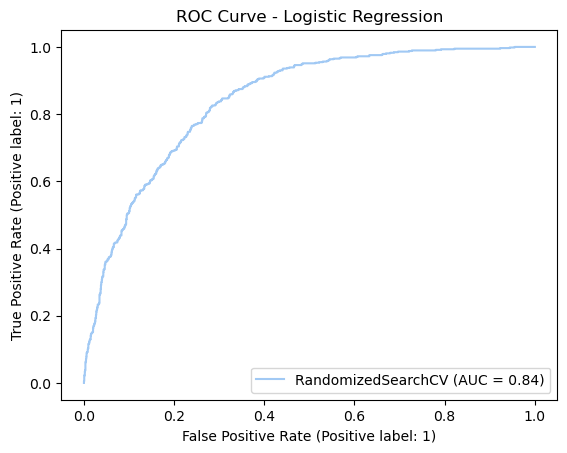

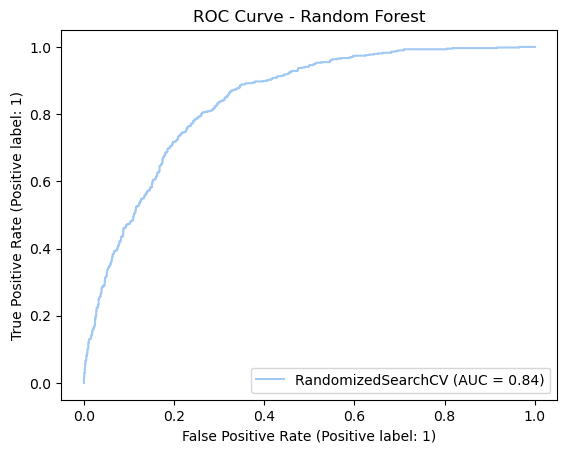

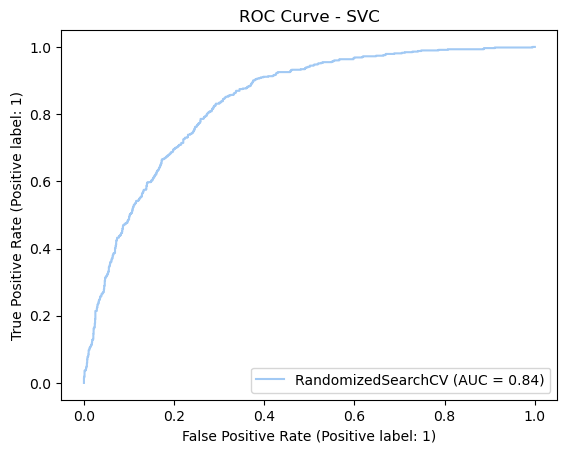

In [32]:
models = {'KNN': knn,
          'Logistic Regression': rs_log_reg,
          'Random Forest': rs_rf,
          'SVC': rs_svc}
print_roc_curve(models, X_test, y_test)

In [33]:
# Make predictions with our best tuned models of each kind
np.random.seed(42)

y_preds_log = rs_log_reg.predict(X_test)
y_preds_rf = rs_rf.predict(X_test)
y_preds_knn = knn.predict(X_test)
y_preds_svc = rs_svc.predict(X_test)


predictions = {'Logistic Regression': y_preds_log,
               'KNN': y_preds_knn,
               'Random Forest': y_preds_rf,
               'SVC': y_preds_svc}

def class_reports(predictions):
    
    # Print all the Classification Reports
    for name, pred in predictions.items():
        print(name)
        print(classification_report(y_test, pred))
        print('')

In [34]:
class_reports(predictions)

Logistic Regression
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1539
           1       0.58      0.66      0.62       574

    accuracy                           0.78      2113
   macro avg       0.72      0.74      0.73      2113
weighted avg       0.79      0.78      0.78      2113


KNN
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1539
           1       0.71      0.36      0.48       574

    accuracy                           0.79      2113
   macro avg       0.76      0.65      0.67      2113
weighted avg       0.78      0.79      0.76      2113


Random Forest
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1539
           1       0.59      0.65      0.62       574

    accuracy                           0.78      2113
   macro avg       0.73      0.74      0.73      2113
weighted avg       0.79      0.78 

We notice that the recall value of the logistic regression model is the highest; it is not as high as I would like, but that is something I will continue to work on.